<a href="https://colab.research.google.com/github/zcvpal2/Aiffel-follow-deep-learning/blob/main/9%2C_aiffel_%EC%B9%B4%EB%A9%94%EB%9D%BC_%EC%8A%A4%ED%8B%B0%EC%BB%A4%EC%95%B1_%EB%A7%8C%EB%93%A4%EA%B8%B0(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

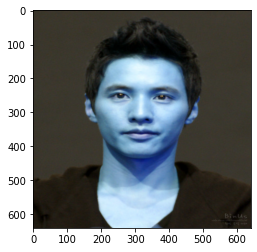

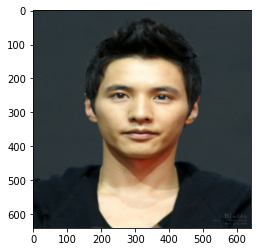

rectangles[[(171, 171) (438, 439)]]


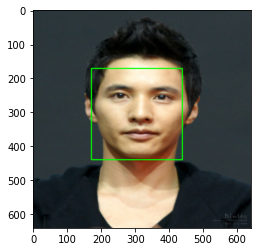

In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

my_image_path =  '/content/drive/MyDrive/AIFFEL/cameta_sticker/images/image.png'
img_bgr = cv2.imread(my_image_path)    
img_bgr = cv2.resize(img_bgr, (640, 640))    
img_show = img_bgr.copy()      
plt.imshow(img_bgr)
plt.show()

# RGB 이미지로 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

import dlib
detector_hog = dlib.get_frontal_face_detector()   # detector 

# bounding box 추출
dlib_rects = detector_hog(img_rgb, 1)  

print(dlib_rects)   # 찾은 얼굴영역 좌표

# 찾은 얼굴 출력
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [5]:
## 이목구비의 위치를 추론하는 것을 face landmark localization이라 한다.
# 객체 내부의 점을 찾는 기술을 object keypoint estimation이라 한다 
# 방법 1. top-down : bounding box를 찾고 box 내부의 keypoint를 예측
# 방법 2. bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성
# dlib는 https://ibug.doc.ic.ac.uk/resources/facial-point-annotations/ 으로 학습한 pretrained model 제공

model_path = '/content/drive/MyDrive/AIFFEL/cameta_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    ## point는  dlib.full_object_detection의 객체 
    ## parts() 함수로 개별 위치에 접근. 
    ## 더 직관적인 (x, y) 형태로 접근
    ## list_points 는 tuple(x,y) 68개로 이루어진 리스트
    list_landmarks.append(list_points) 

print(len(list_landmarks[0]))

68


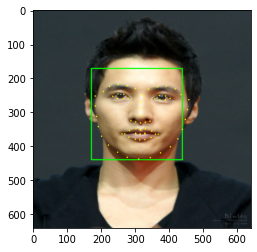

In [6]:
## 랜드마크 출력
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [7]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(315, 309)
(x,y) : (315,175)
(w,h) : (268,268)


In [8]:
## 왕관 이미지 가지고 오기
sticker_path = '/content/drive/MyDrive/AIFFEL/cameta_sticker/images/king.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(268, 268, 3)


In [9]:
## 이미지 크기를 resize
refined_x = x - w // 2  # left
refined_y = y - h       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (181,-93)


In [10]:
## opencv 데이터는 numpy ndarray 형태의 데이터
## ndarray는 음수 인덱스에 접근할 수 없기 때문에 
## 음수에 대한 예외 처리
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (181,0)


In [12]:
## 원본 이미지에 스티커 적용
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

## 스티커는 0이 아닌 부분을 사용해야 그렇기 때문에 np.where를 통해 0인 부분은 area로

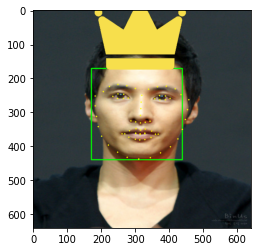

In [13]:

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

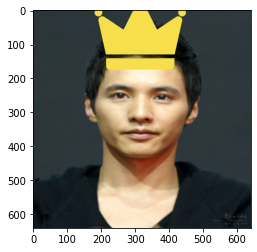

In [14]:
### bounding box와 landmark 제거
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()